#Preparation

####Importing libraries and mounting Google Drive

In [ ]:
# Basic libraries
import os
import pandas as pd
import numpy as np 
from joblib import dump, load
import six
from google.colab import drive
drive.mount('/content/drive')

# Clustering
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import sklearn.utils

# Vizualization
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
%matplotlib inline
from PIL import Image
# Installing cartopy library from command line
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip uninstall shapely
!pip install shapely --no-binary shapely
!pip install cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

####Defining the function needed

In [2]:
# def make_map(projection=ccrs.PlateCarree()):
#   fig, ax = plt.subplots(figsize=(14, 10),
#                          subplot_kw=dict(projection=projection))
#   gl = ax.gridlines(draw_labels=True)
#   gl.xlabels_top = gl.ylabels_right = False
#   gl.xformatter = LONGITUDE_FORMATTER
#   gl.yformatter = LATITUDE_FORMATTER
#   return fig, ax

def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

####Loading the dataset as Panda DataFrame

In [3]:
root = '/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita'

# loading the file
geotag_df = pd.read_csv(root+'/CSV/2010-2019_ready.csv')
geotag_df.set_index('photo_id', inplace=True)
print ("Shape of the DataFrame: ", geotag_df.shape)

owner_list = geotag_df.owner_nsid.unique()
owner_df = pd.DataFrame({'owner_nsid': owner_list})
#print(owner_df.head())

geotag_test = geotag_df.sample(5000)
owner_test = owner_df.sample(200)
#print(owner_test)

Shape of the DataFrame:  (44335, 8)


In [4]:
# defining the maps border
lower_longitude = 115.03
upper_longitude = 115.4033
lower_latitude = -8.886667
upper_latitude = -8.413333
extent = [lower_longitude, upper_longitude, lower_latitude, upper_latitude]

# Filtering data based on the coordinate
geotag_df = geotag_df.loc[(geotag_df['location_longitude'] > lower_longitude) &
                          (geotag_df['location_longitude'] < upper_longitude) &
                          (geotag_df['location_latitude'] > lower_latitude) &
                          (geotag_df['location_latitude'] < upper_latitude)]
print ("Shape of the DataFrame: ", geotag_df.shape)
geotag_df.head()

Shape of the DataFrame:  (32472, 8)


,Source.Name,owner_nsid,owner_location,dates_taken,date,hours,location_latitude,location_longitude
photo_id,,,,,,,,
4309283024,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 11:37,25-Jan-10,11:37:00 AM,-8.794026,115.227978
4308548011,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 11:38,25-Jan-10,11:38:00 AM,-8.794026,115.227978
4309288184,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 15:05,25-Jan-10,3:05:00 PM,-8.794026,115.227978
4308548897,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 18:38,25-Jan-10,6:38:00 PM,-8.794026,115.227978
4308550141,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 18:44,25-Jan-10,6:44:00 PM,-8.794026,115.227978


#Visualization

####User Photomap

In [5]:
i = 0
total_user = len(owner_test.index)
plt.ioff()

for index, row in owner_test.iterrows():
	cimgt.GoogleWTS.get_image = new_get_image
	request = cimgt.GoogleTiles()

	fig = plt.figure(figsize=(9,6))
	mymap = plt.axes(projection=ccrs.PlateCarree())
	mymap.set_extent(extent)
	mymap.add_image(request, 10)
	
	plot_df = geotag_df.loc[geotag_df['owner_nsid'] == row.owner_nsid]
	#print(current_owner_nsid)

	total_nodes = len(geotag_df.index)
	for index,row in plot_df.iterrows():
		mymap.plot(row.location_longitude, row.location_latitude, markerfacecolor = 'blue', markeredgecolor = 'yellow', marker = 's', markersize = 10, alpha = 0.6)
	plt.title("Photo map of user: {0}" .format(row.owner_nsid), fontsize=14)
	#plt.savefig("/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Maps/User Photomap/{0}.png" .format(row.owner_nsid), dpi=300)
	plt.close(fig)
	i += 1
	if i % 50 == 0:
		print('{0} / {1} user photo map created.' .format(i, total_user))
    #plt.show()
print('Total of {0} user photo map created.' .format(i))

50 / 200 user photo map created.
100 / 200 user photo map created.
150 / 200 user photo map created.
200 / 200 user photo map created.
Total of 200 user photo map created.


####Distribution Map

5000 / 32472 nodes plotted to the map.
10000 / 32472 nodes plotted to the map.
15000 / 32472 nodes plotted to the map.
20000 / 32472 nodes plotted to the map.
25000 / 32472 nodes plotted to the map.
30000 / 32472 nodes plotted to the map.
Total of 32472 nodes has been plotted to the map.


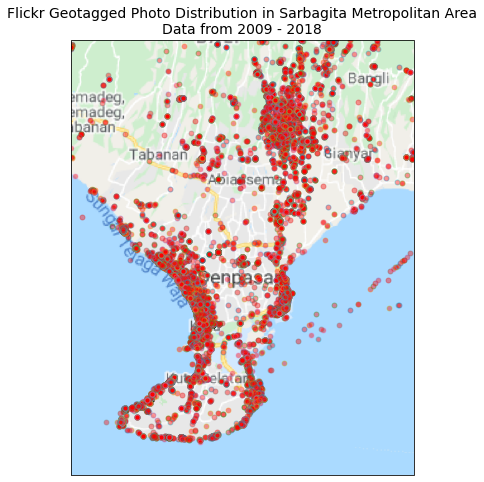

In [6]:
cimgt.GoogleWTS.get_image = new_get_image
request = cimgt.GoogleTiles()

fig = plt.figure(figsize=(8, 8))
mymap = plt.axes(projection=ccrs.PlateCarree())
mymap.set_extent(extent)
mymap.add_image(request, 10)

i = 0
total_nodes = len(geotag_df.index)
for index,row in geotag_df.iterrows():
    mymap.plot(row.location_longitude, row.location_latitude, markerfacecolor = 'red', marker = '.', markersize = 10, alpha = 0.4)
    i += 1
    if i % 5000 == 0:
        print('{0} / {1} nodes plotted to the map.' .format(i, total_nodes))
print('Total of {0} nodes has been plotted to the map.' .format(i))
#plt.text(x,y,stn)

plt.title("Flickr Geotagged Photo Distribution in Sarbagita Metropolitan Area\nData from 2009 - 2018", fontsize=14)
#plt.savefig("/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/Maps/Distribution Map.png", dpi=1200)
plt.show()

#Clustering

#####Loading the longitude and latitude data into a new dataframe

In [7]:
# Taking longitude and latitude data from the geotag_df
geotag_clus = geotag_df[['location_longitude', 'location_latitude']]
print ("Shape of the DataFrame: ", geotag_clus.shape)
print(geotag_clus.head())

# standardize the feature
geotag_clus_scaled = StandardScaler().fit_transform(geotag_clus)
pd.set_option('precision',8)
geotag_clus_scaled = pd.DataFrame(data=geotag_clus_scaled, columns=['location_longitude', 'location_latitude'])
print(geotag_clus_scaled.head())

Shape of the DataFrame:  (32472, 2)
            location_longitude  location_latitude
photo_id                                         
4309283024          115.227978          -8.794026
4308548011          115.227978          -8.794026
4309288184          115.227978          -8.794026
4308548897          115.227978          -8.794026
4308550141          115.227978          -8.794026
   location_longitude  location_latitude
0          0.31867038        -1.27558259
1          0.31867038        -1.27558259
2          0.31867038        -1.27558259
3          0.31867038        -1.27558259
4          0.31867038        -1.27558259


####OPTICS

#####Benchmarking the `min_samples`, `xi`, and `min_cluster_size` to find the optimal parameter

In [ ]:
optics_result = []
i = 0
min_samples = [10, 50, 100]
xi = [0.5, 0.1]
min_cluster_size = [0.01, 0.5, 0.1]

for x in min_samples:
	for y in xi:
		for z in min_cluster_size:
			optics_model = OPTICS(min_samples=x, xi=y, min_cluster_size=z)

			optics_model.fit(geotag_clus_scaled)
			labels = optics_model.labels_
			if len(set(labels)) < 2:
				n_noise_ = 'Invalid model: Cluster < 2'
				silhouette_score = 'Invalid model: Cluster < 2'
				n_clusters_ = 'Invalid model: Cluster < 2'
				print('Error when trying with the following parameter: min_samples={0}, xi={1}, min_cluster_size={2}' .format(x, y, z))
				break
			else:
				n_noise_ = list(labels).count(-1)
				silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)
				n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
				
				result = {'min_samples': x,
									'xi': y,
									'min_cluster_size': z,
									'n_clusters_': n_clusters_,
									'n_noise_': n_noise_,
									'silhouette_score': silhouette_score}
				optics_result.append(result)
				i += 1
				if i % 10 == 0:
					print('%d / 125 model has been made' % i)

optics_benchmark_df = pd.DataFrame(optics_result)
optics_benchmark_df.head()
# optics_benchmark_df.to_csv('/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/CSV/OPTICS Clustering Benchmark.csv')

#####Clustering the dataset using the `min_samples`, `xi`, and `min_cluster_size` from the benchmarking result

In [10]:
# Building the OPTICS Clustering model 
min_samples = 50
xi = 0.04
min_cluster_size = 0.08
optics_model = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size) 

# Training the model 
optics_model.fit(geotag_clus_scaled)

# Storing the cluster labels of each point 
labels = optics_model.labels_#[optics_model.ordering_] 
geotag_clus['cluster'] = optics_model.labels_
  
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Silhouette Coefficient: %0.3f' % silhouette_score)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Estimated number of clusters: 3
Estimated number of noise points: 18292
Silhouette Coefficient: 0.275


#####Drawing the cluster on map

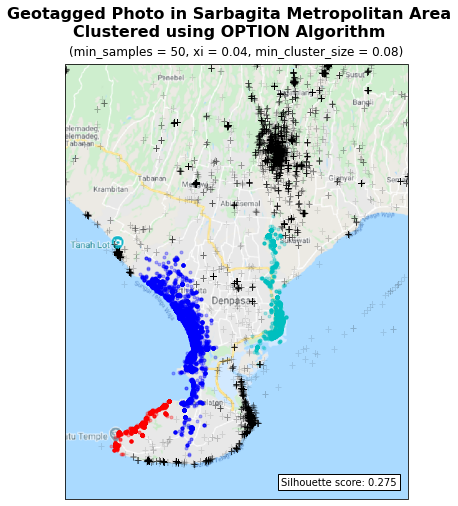

In [15]:
cimgt.GoogleWTS.get_image = new_get_image
request = cimgt.GoogleTiles()

fig = plt.figure(figsize=(8,8))
mymap = plt.axes(projection=ccrs.PlateCarree())
mymap.set_extent(extent)
mymap.add_image(request, 11)

# adding silhouette_score to the plot
props = dict(boxstyle='square', facecolor='white', alpha=1)
mymap.text(0.63, 0.05, 'Silhouette score: %.3f' % silhouette_score, transform=mymap.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

colors = ['c.', 'b.', 'r.', 'y.', 'g.', 'm.']

for Class, colour in zip(range(0, n_clusters_), colors): 
  Xk = geotag_clus.loc[geotag_clus['cluster'] == Class]
  mymap.plot(Xk['location_longitude'], Xk['location_latitude'], colour, alpha = 0.3) 
geotag_clus['location_longitude'].loc[geotag_clus['cluster'] == -1]
# plotting the outlier
mymap.plot(geotag_clus['location_longitude'].loc[geotag_clus['cluster'] == -1],
           geotag_clus['location_latitude'].loc[geotag_clus['cluster'] == -1], 
           'k+', alpha = 0.1) 

plt.suptitle('Geotagged Photo in Sarbagita Metropolitan Area\nClustered using OPTION Algorithm', fontsize=16, fontweight=600, ha='center', va='top')
plt.title('(min_samples = {0}, xi = {1}, min_cluster_size = {2})' .format(min_samples, xi, min_cluster_size), fontsize=12, ha='center', va='bottom')
# plt.savefig("/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/Maps/OPTICS({0}, {1}, {2}).png" .format(min_samples, xi, min_cluster_size), dpi=1200)

plt.show()

##### Adding the cluster label to dataframe and exporting it to csv

In [ ]:
# exporting the clustered dataframe into a csv file
clustered_geotag_df = geotag_df
clustered_geotag_df['cluster'] = geotag_clus['cluster']
clustered_geotag_df.to_csv('/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/CSV/2009-2018_Clustered using OPTICS ({0}, {1}, {2}).csv' .format(min_samples, xi, min_cluster_size))

####DBSCAN

#####Benchmarking the `eps` and `min_samples` to find the optimal parameter

In [ ]:
dbscan_result = []
eps = [i for i in numpy.arange(0.05, 1, 0.05)]
min_samples = [i for i in range(100, 5000, 100)]
i = 0
total_combination = len(eps) * len(min_samples)

for x in eps:
  for y in min_samples:
    db = DBSCAN(eps=x, min_samples=y).fit(geotag_clus_scaled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if n_clusters_ < 2:
      silhouette_score = 'invalid n_cluster'
    else:
      silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)
      
    result = {'eps': x,
              'min_samples': y,
              'n_clusters_': n_clusters_,
              'n_noise_': n_noise_,
              'silhouette_score': silhouette_score}
    dbscan_result.append(result)
    i += 1
    if i % 10 == 0:
      print('{0} / {1} model has been tested' .format(i, total_combination))
    elif  i % total_combination == 0:
      print('Benchmarking done with {0} parameter combination.' .format(total_combination))

dbscan_benchmark_df = pd.DataFrame(dbscan_result)
dbscan_benchmark_df.head()
dbscan_benchmark_df.to_csv('/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/CSV/DBSCAN Clustering Benchmark.csv')

#####Clustering the dataset using the `eps` and `min_samples` from the benchmarking result

In [16]:
# Setting parameter for DBSCAN
eps = 0.35
min_samples = 1500

# Computing DBSCAN
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
db = dbscan_model.fit(geotag_clus_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
geotag_clus['cluster'] = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Estimated number of clusters: 6
Estimated number of noise points: 3596
Silhouette Coefficient: 0.576


#####Drawing the cluster on map

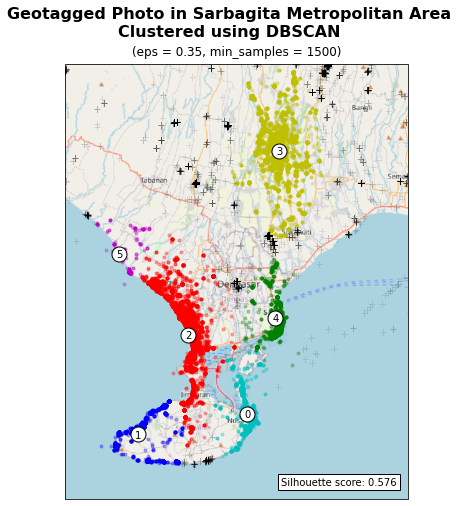

In [17]:
# Setting parameter for DBSCAN
eps = 0.35
min_samples = 1500

cimgt.GoogleWTS.get_image = new_get_image
request = cimgt.OSM()
# request = cimgt.GoogleTiles()

fig = plt.figure(figsize=(8,8))
mymap = plt.axes(projection=ccrs.PlateCarree())
mymap.set_extent(extent)
mymap.add_image(request, 11)

# adding silhouette_score to the plot
props = dict(boxstyle='square', facecolor='white', alpha=1)
mymap.text(0.63, 0.05, 'Silhouette score: %.3f' % silhouette_score, transform=mymap.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

colors = ['c.', 'b.', 'r.', 'y.', 'g.', 'm.', 'w.']

# plotting cluster
center_point = geotag_clus.groupby('cluster').mean()
for Class, colour in zip(range(0, n_clusters_), colors): 
  Xk = geotag_clus.loc[geotag_clus['cluster'] == Class]
  mymap.plot(Xk['location_longitude'], Xk['location_latitude'], colour, alpha = 0.3)
  mymap.annotate(str(Class),xy=(center_point.at[Class, 'location_longitude']-0.003,
                                center_point.at[Class, 'location_latitude']-0.004))
  mymap.plot(center_point.at[Class, 'location_longitude'],
             center_point.at[Class, 'location_latitude'],
             'wo', mec='k', ms=15, alpha=1) 

# plotting outlier
mymap.plot(geotag_clus['location_longitude'].loc[geotag_clus['cluster'] == -1],
           geotag_clus['location_latitude'].loc[geotag_clus['cluster'] == -1], 
           'k+', alpha = 0.1)

plt.suptitle('Geotagged Photo in Sarbagita Metropolitan Area\nClustered using DBSCAN', fontsize=16, fontweight=600, ha='center', va='top')
plt.title('(eps = {0}, min_samples = {1})' .format(eps, min_samples), fontsize=12, ha='center', va='bottom')
# plt.savefig("/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/Maps/DBSCAN ({0}, {1})_1.png" .format(eps, min_samples), dpi=1200)

plt.show()

##### Adding the cluster label to dataframe and exporting it to csv

In [ ]:
# exporting the clustered dataframe into a csv file
clustered_geotag_df = geotag_df
clustered_geotag_df['cluster'] = geotag_clus['cluster']
clustered_geotag_df.to_csv(root+'/CSV/2010-2019_Clustered using DBSCAN ({0}, {1}).csv' .format(eps, min_samples))

#### Model Reusability

##### Save model

In [18]:
dump(dbscan_model, root+'/dbscan_model.joblib')

['/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/dbscan_model.joblib']

##### Load model

In [19]:
# Computing DBSCAN
loaded_model = load(root+'/dbscan_model.joblib')
db = loaded_model.fit(geotag_clus_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
geotag_clus['cluster'] = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Estimated number of clusters: 6
Estimated number of noise points: 3596
Silhouette Coefficient: 0.576


In [20]:
# exporting the clustered dataframe into a csv file
clustered_geotag_df = geotag_df
clustered_geotag_df['cluster'] = geotag_clus['cluster']
# clustered_geotag_df.to_csv(root+'/2009-2018_Clustered using DBSCAN ({0}, {1}).csv' .format(0.4, 1800))

clustered_geotag_df.head()

,Source.Name,owner_nsid,owner_location,dates_taken,date,hours,location_latitude,location_longitude,cluster
photo_id,,,,,,,,,
4309283024,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 11:37,25-Jan-10,11:37:00 AM,-8.794026,115.227978,0
4308548011,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 11:38,25-Jan-10,11:38:00 AM,-8.794026,115.227978,0
4309288184,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 15:05,25-Jan-10,3:05:00 PM,-8.794026,115.227978,0
4308548897,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 18:38,25-Jan-10,6:38:00 PM,-8.794026,115.227978,0
4308550141,2010_dirty.csv,33389995@N08,AUSTRALIA,25-01-10 18:44,25-Jan-10,6:44:00 PM,-8.794026,115.227978,0
